# Hopfield Network With Hashing - Hopfield

This is a memory mechanism in a form of a Hopfield network. The stored items are called memory patterns. They are retrieved by a process of the input that is presented to the network dynamics which at some time step reaches a fixed stable point. This means that the input item has been recognized (i.e. there is a memory pattern identical or very similar to it).

Even noisy sounds or those corrupted to some extent can be accessed. In other words, if the input is $x_1 + \delta$ and the stored item is $x_1$, the network will still reach the fixed point of $x_1$ if $\delta$ is small enough.

Additionally, for storage purposes, sounds are transformed each into a hash - with this we reduce their dimensionality. This means we increase the storage capacity. 

In [95]:
# First, we load the neccessary dependencies.

import numpy as np
import math
from python_speech_features import mfcc
import scipy.io.wavfile as wav
import sys
import glob
import random
import matplotlib.pyplot as plt

In [96]:
# Folder with some wav files to test this script.
folder_train = "./waveforms/"

First, we will transform our .wav files into features, in this case MFCCs.

In [97]:
# Go through the folder and find all (and only) files ending with .wav
# Here, we transform each .wav file into MFCCs and then flatten them into one vector
# We do this because we want one hash per .wav file
#
# Arguments: sound folder
# Returns: a list of flattened MFCC vectors

def make_mfcc(folder):
    vectors = []
    for file in glob.glob(folder + "*.wav", recursive=True):
        (rate,sig) = wav.read(file)
        mfcc_feat = mfcc(sig,rate)
        vect = mfcc_feat.flatten()
        vectors.append(vect)
    return vectors

Now we will use these features and transform them into hash vectors, which we will use to store in our memory.

In [98]:
# Transform a vector of speech into a hash
# The hash will be a matrix of the dimension = k*m
# We choose a random number k of units of the vector.
# And look for the highest value and turn it into 1.
# Everything else is 0.
# We thus get sparse matrices.
# We do this m times. Final output is h=k*m.


def get_hash(vector, k, m):
    d = len(vector)
    p = np.zeros((m,k,))
    for i in range(m):
        p[i] = np.random.permutation(d)[:k]
        
    h = np.zeros((m,k,))
    for i in range(m):
        ix = np.argmax(p[i])
        hi = np.zeros(k)
        hi[ix] = 1
        h[i] = hi
    h = np.hstack(h)
    return h

We must now construct our neuron weight matrix that reopresents the connections between neurons of our memory network.

In [99]:
# Function for the matrix T (symmetric recurrent weight matrix)
#
# Arguments: 
# N (number of neurons), V (list of vectors in a hash form)

def get_T(N, V):

    T_sum = np.zeros((N,N))
    for vect in V:
        outer_prod = np.outer((2*vect - 1),(2*vect - 1))
        T_sum += outer_prod
        
    return T_sum

To see when we have reached a stable fixed point, we use the energy function E, which is a monotonically decreasing function - state changes continue until a local E is reached.

In [100]:
# Function for establishing the fixed (stable) point
# E = - delta(V_i) * sum_j (T_ij * V_j)
#
# Arguments of the function 'energy':
#
# x0 - input vector for which we are establishing whether
# it is similar to one of the stored memories or not
# T - symmetric recurrent weight matrix
# treshold - used to estimate whether the energy function has
# not been decreasing for more than the given threshold


def energy(x0, T, V, treshold):
    E_t1 = 0
    E = []
    timestep = 0
    for i in range(T.shape[0]):
        for j in range(len(V)):
            for k in range(len(V)):
                E_t = E_t1
                E_t1 -= 1/2 * (T[i,j] * x0[j] * V[k][j])
                timestep += 1
                E.append(E_t1)
#         if abs(E_t - E_t1) < treshold:
#             print("Timestep of this energy function was: " + str(timestep))
        return E
        

We can now inspect our memory network and test it:

In [101]:
# Test with random dimensions k, m, N, which determine the size of T and of hash vectors:

k = 5
m = 3
N = 15
V =[]

mfccs_vectors = make_mfcc(folder_train)
for vect in mfccs_vectors:
    v = get_hash(vect, 5, 3)
    V.append(v)

T = get_T(N, V)

Important assumption here is that Hopfield uses $V_i$ as a state of neuron activation which can have a value 0 ("not firing") or 1 ("maximally firing"). We also obtained 1s and 0s for hashing purposes (you can see what a vector will look like in a cell below). I am therefore here making an assumption that values in the hash vector equate whether the neuron is active or not, since I do not know how else to obtain the neuron activation (this assumption may be wrong). 

In [102]:
# We can inspect how one of our hashed vectors looks like:
print(V[0])

[0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]


We can also see here how our matrix T (symmetric recurrent weight matrix) looks like:

In [103]:
# We can inspect how our transition matrix looks like:
print(T)

[[ 9.  5.  3.  1.  3.  5.  1.  9.  1.  5.  3.  7.  3.  3.  5.]
 [ 5.  9.  3.  1.  3.  5.  5.  5.  1.  5.  7.  3.  3.  3.  5.]
 [ 3.  3.  9. -1.  1.  3.  3.  3.  3.  3.  1.  1.  1.  9.  3.]
 [ 1.  1. -1.  9. -1.  5. -3.  1.  1.  5.  3. -1.  3. -1.  5.]
 [ 3.  3.  1. -1.  9.  3.  3.  3.  3.  3.  1.  5.  5.  1.  3.]
 [ 5.  5.  3.  5.  3.  9.  1.  5.  1.  5.  3.  3.  3.  3.  9.]
 [ 1.  5.  3. -3.  3.  1.  9.  1. -3.  1.  3.  3. -1.  3.  1.]
 [ 9.  5.  3.  1.  3.  5.  1.  9.  1.  5.  3.  7.  3.  3.  5.]
 [ 1.  1.  3.  1.  3.  1. -3.  1.  9.  1.  3. -1.  3.  3.  1.]
 [ 5.  5.  3.  5.  3.  5.  1.  5.  1.  9.  3.  3.  7.  3.  5.]
 [ 3.  7.  1.  3.  1.  3.  3.  3.  3.  3.  9.  1.  1.  1.  3.]
 [ 7.  3.  1. -1.  5.  3.  3.  7. -1.  3.  1.  9.  1.  1.  3.]
 [ 3.  3.  1.  3.  5.  3. -1.  3.  3.  7.  1.  1.  9.  1.  3.]
 [ 3.  3.  9. -1.  1.  3.  3.  3.  3.  3.  1.  1.  1.  9.  3.]
 [ 5.  5.  3.  5.  3.  9.  1.  5.  1.  5.  3.  3.  3.  3.  9.]]


Now we will test our memory and see what the energy function of a vector already stored in memory is and compare it to a vector not stored in memory:

In [104]:
# Let us now see how the energy function works when we tested it:
# E_test is a vector impossible to obtain from our hashing method - 
# it should show no fixed point
# E_V0 uses as test the first hashed vector (identical to the stored data)
E_test = energy([1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], T, V, 0.000001)
E_V0 = energy(V[0], T, V, 0.000001)

# We can see the energy as it gradually stabilizes
print(energy([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], T, V, 0.000001))

[0.0, -4.5, -4.5, -4.5, -4.5, -4.5, -4.5, -4.5, -4.5, -4.5, -4.5, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -7.0, -8.5, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.0, -10.5, -11.0, -11.5, -13.0, -13.0, -13.0, -13.0, -13.0, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5, -14.5]


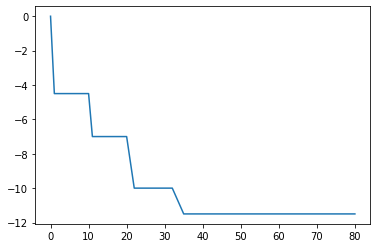

In [105]:
# Let's plot the data

plt.plot(E_test)
plt.show()

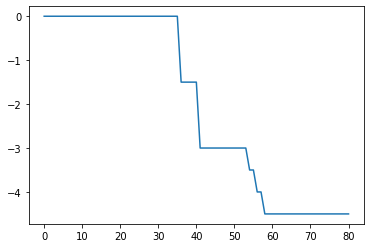

In [106]:
# And here is the energy data from our vector identical to stored memory
plt.plot(E_V0)
plt.show()